# ARIMA model

In [46]:
#importing libraries and tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pmdarima import auto_arima
from matplotlib import rcParams

import warnings
warnings.filterwarnings("ignore")

In [47]:
# default plot size
rcParams['figure.figsize'] = 8,8

In [48]:
#Importing data from EIA(Energy Information Administration)
oil_df = pd.read_csv('D:\myDocuments\oil project\dfoil.csv', index_col=0,parse_dates=True)
oil_df_transformed = pd.read_csv('D:\myDocuments\oil project\dfoil_transformed.csv', index_col=0,parse_dates=True)

In [49]:
#overviewing dataframes
display(oil_df.head(5))
display(oil_df_transformed.head(5))

,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
1997-01-07,344.709677,26.250000,17352.142857,6479.714286,837012.285714
1997-01-08,345.161290,26.550000,17596.428571,6486.142857,837598.857143
1997-01-09,345.612903,26.300000,17840.714286,6492.571429,838185.428571
1997-01-10,346.064516,26.150000,18085.000000,6499.000000,838772.000000
1997-01-11,346.516129,25.833333,18160.571429,6495.714286,838473.000000


,oilrig_count,oil_price,oilconsumption,oilproduction,oilstorage
1997-01-09,0.903226,0.050000,488.571429,12.857143,1173.142857
1997-01-10,0.903226,-0.400000,488.571429,12.857143,1173.142857
1997-01-11,0.903226,-0.466667,319.857143,3.142857,287.571429
1997-01-12,0.903226,-0.633333,151.142857,-6.571429,-598.000000
1997-01-13,0.903226,-0.633333,151.142857,-6.571429,-598.000000


OIL RIGS PREDICTION

In [50]:
period = 12

In [51]:
stepwise_fit = auto_arima(oil_df['oilrig_count'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=period,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)          

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=-7715.780, Time=0.88 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=-7719.780, Time=0.33 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=-7715.780, Time=1.15 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=-7715.780, Time=1.12 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=-7717.780, Time=0.88 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=-7717.780, Time=0.68 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=-7717.780, Time=0.40 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=-7717.780, Time=1.22 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=-7715.780, Time=0.51 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=-7717.781, Time=0.69 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 7.892 seconds


Splitting the data into train and test data set.

In [52]:
train = oil_df.iloc[:len(oil_df)-period]
test = oil_df.iloc[len(oil_df)-period:]

Training ARIMA model

In [53]:
oil_model = ARIMA(train['oilrig_count'],order=(0,2,0))
oil_results = oil_model.fit()

Sample Forecasting against known values

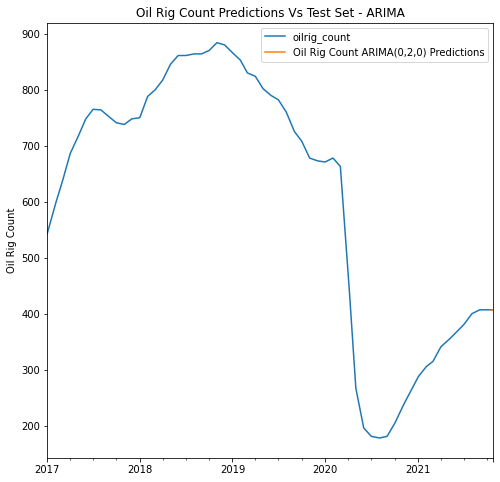

In [54]:
start=len(train)
end=len(train)+len(test)-1
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count ARIMA(0,2,0) Predictions')

# Plot predictions
title = 'Oil Rig Count Predictions Vs Test Set - ARIMA'
ylabel='Oil Rig Count'
xlabel=''

ax = oil_df['oilrig_count'].loc['2017':].plot(legend=True,title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Evaluating Model Performance

In [55]:
RMSE1 = rmse(oil_df['oilrig_count'].loc[test.index.min():],oil_predictions)
MSE1 = mse(oil_df['oilrig_count'].loc[test.index.min():],oil_predictions)
MAE1 = meanabs(oil_df['oilrig_count'].loc[test.index.min():],oil_predictions)

print(f"""Oil Rig ARIMA(3,1,1) RMSE: {RMSE1:.3f}
Oil Rig ARIMA(0,2,0) MSE: {MSE1:.3f}
Oil Rig ARIMA(0,2,0) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {oil_df['oilrig_count'][-period:].mean():.3f}
Oil Rig std Value: {oil_df['oilrig_count'][-period:].std():.3f}
Oil Rig Percent Change: {RMSE1/oil_df['oilrig_count'][-period:].mean()*100:.3f}%""")

Oil Rig ARIMA(3,1,1) RMSE: 0.000
Oil Rig ARIMA(0,2,0) MSE: 0.000
Oil Rig ARIMA(0,2,0) MAE: 0.000

Oil Rig Mean Value: 407.000
Oil Rig std Value: 0.000
Oil Rig Percent Change: 0.000%


In [56]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_oil = []
MSE_oil = []
MAE_oil = []
for train_index, test_index in tscv.split(oil_df['oilrig_count']):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train, test = oil_df['oilrig_count'][train_index], oil_df['oilrig_count'][test_index]
    oil_model = ARIMA(train,order=(0,2,0))
    oil_results = oil_model.fit()
    start=len(train)
    end=len(train)+len(test)-1
    oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels')   
    RMSE_oil.append('{:.3f}'.format(rmse(oil_df.loc[oil_df.index[test_index],'oilrig_count'],oil_predictions)))
    MSE_oil.append('{:.3f}'.format(mse(oil_df.loc[oil_df.index[test_index],'oilrig_count'],oil_predictions)))
    MAE_oil.append('{:.3f}'.format(meanabs(oil_df.loc[oil_df.index[test_index],'oilrig_count'],oil_predictions)))

RMSE_oil = np.array(RMSE_oil).astype('float')
MSE_oil = np.array(MSE_oil).astype('float')
MAE_oil = np.array(MAE_oil).astype('float')
print(f"""\n10-fold Cross Validation Oil Rig
RMSE: {RMSE_oil.mean():.3f}
MSE: {MSE_oil.mean():.3f}
MAE: {MAE_oil.mean():.3f}\n
Oil Rig Mean Value: {oil_df['oilrig_count'][-period:].mean():.3f}
Oil Rig std Value: {oil_df['oilrig_count'][-period:].std():.3f}
Oil Rig Percent Change: {RMSE_oil.mean()/oil_df['oilrig_count'][-period:].mean()*100:.3f}%""")

TRAIN: 8938 TEST: 12
TRAIN: 8950 TEST: 12
TRAIN: 8962 TEST: 12
TRAIN: 8974 TEST: 12
TRAIN: 8986 TEST: 12
TRAIN: 8998 TEST: 12
TRAIN: 9010 TEST: 12
TRAIN: 9022 TEST: 12
TRAIN: 9034 TEST: 12
TRAIN: 9046 TEST: 12

10-fold Cross Validation Oil Rig
RMSE: 0.134
MSE: 0.076
MAE: 0.087

Oil Rig Mean Value: 407.000
Oil Rig std Value: 0.000
Oil Rig Percent Change: 0.033%


After Evaluation, Fitting Model with 100% data for Real Future Prediction

In [57]:
#fitting model
startTime = time.time()
oil_model = ARIMA(oil_df['oilrig_count'],order=(0,2,0))
oil_results = oil_model.fit()

start=len(oil_df)
end=len(oil_df)+period
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count ARIMA(0,2,0) Predictions')
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 0.3151569366455078


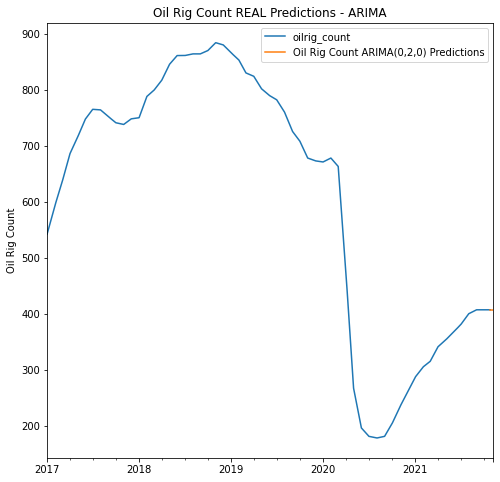

In [58]:
title = 'Oil Rig Count REAL Predictions - ARIMA'
ylabel='Oil Rig Count'
xlabel=''

ax = oil_df['oilrig_count'].loc['2017':].plot(legend=True,title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);